## Part I: Machine Learning
Machine Learning aims at learning from data, either by learning from user annotations (="labels") and predicting for previously unseen data -- which is called supervised learning -- or by analyzing huge amounts of data without annotations -- called unsupervised learning. One important direction in supervised learning is classification. In classification, there are several classes of objects, and depending on their properties these should be distinguished. Simple example: in a table of numbers containing features like *number of legs* and *weight* separate cats and birds. So in classification one wants to predict a categorical label per sample.

In this exercise we will look at a classification method called the **Random Forest**:

A Random Forest is a **supervised** machin learning technique. This means you train the Random Forest by presenting it a set of examples where you know the type/class/label of each sample. 

Assume we have given a matrix containing 10 features each of 100 objects, and a vector of labels $\in\{0,1\}$ for each object:

In [43]:
features.shape

(100, 10)

In [44]:
labels.shape

(100,)

You can then create a random forest and fit it to the examples by using the following:

In [55]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier() # create Random Forest
rf.fit(features, labels) # fit to samples with these features and labels

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

If you have the features of some previously unseen objects, you can then predict their class using the Random Forest's ```predict``` method:

In [56]:
otherlabels = rf.predict(otherfeatures)

> #### Side Note: Object oriented programming
> rf contains a more complicated "object" than just a number or list now. This object provides methods and also has some state. It is an instance of the **class** ```RandomForestClassifier```, that implements all the methods and defines what properties every instance of this class will have. When we use the instance rf that we have here, we can change its properties (e.g. make it fit our data). Because this very instance of a ```RandomForestClassifier``` has been trained to classify our special kind of data, it can use this knowledge when you call ```rf.predict(...)```.

## Classifying image pixels
We will now try to classify a neuron tissue electron microscopic image into membrane pixels, cell interior pixels, and mitochondria pixels using a random forest.

* Now load the following <a href="https://github.com/chaubold/pycourse2016/raw/master/rawEMslice.tif">image</a> of a neuron tissue EM slice using ```matplotlib.pyplot.imread```.
* Load this <a href="https://github.com/chaubold/pycourse2016/raw/master/labels.tif">image</a> of user annotations using the same function. 
    * Use all values that contain the gray value 1 as membrane training examples, the ones with pixel value 2 as cell interior training examples, and the ones with pixel value 3 as membrane. Value zero means it should not be used for training.
    * To get all entries of a numpy array ```a``` that have a certain value, use ```a[a == value]```
* Train a random forest using the pixel values from the EM image as the only feature.
    * Can the random forest predict sensible output? Plot the predictions with your own colormap, which you can define as follows:
    ```
    import matplotlib
    colors = np.array([[1,0,0], [0, 1, 0], [0, 0, 1]])
    colormap = matplotlib.colors.ListedColormap ( colors )
    ```
    * Overlay the predictions over the raw image to see how good the predictions are. Use ```plt.imshow(prediction, alpha=0.5)``` to make a transparent overlay.

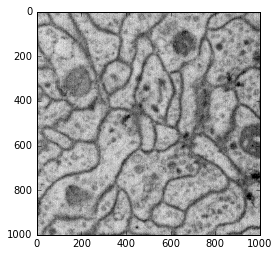

In [66]:
img = plt.imread('rawEMslice.tif')
plt.imshow(img, cmap='gray')

### Adding more features
The prediction can be much better if more features are used. Load the file <a href="https://github.com/chaubold/pycourse2016/raw/master/features.npy">features.npy</a> using ```numpy.load```. It is a three dimensional matrix containing several features per pixel.

* Look at the new features as images. Can you tell what they represent?
* Train a new random forest using these features. Compare the new prediction with the one before where only a single feature was used.
* The trained random forest has a property called "feature\_importances\_" which is a vector that tells you how much each feature helps when determining the class of a pixel. Do the high numbers in there correspond to features that look informative?

# Part II: Linear and nonlinear spatial features for computer vision
So far, we have pretended that the features are simply available. Now it's up to you to compute them. In this part, we reproduce the most important rotation invariant features. 

## The Gaussian 
is an important basic building block. It is a good low-pass / smoothing filter. It has many special properties, for instance a modulated Gaussian is the signal that is best localized in space and in the Fourier domain *simultaneously*. It is the only function that makes the Heisenberg uncertainty inequality tight. It is also "separable", meaning that the 2D function can be factored into two 1D functions. As a consequence, the 2D filter can be obtained by applying two 1D filters, horizontally and vertically. 

* write a function that returns a numpy vector with a **normalized** 1D Gaussian with standard deviation provided as an argument. Adjust the length of the vector automatically to the standard deviation provided to avoid truncation artefacts.  
* write a function for 2D Gaussian filtering, with the image and the std. deviation as arguments. Internally, convolve the image with the 1D Gaussian constructed before, horizontally and vertically. Hint: you can force your 1D numpy array to be interpreted as a 2D array by using the `numpy.newaxis` command, as in `g[:, np.newaxis]`. 
* repeat, for various standard deviations. Observe how different details of the image become blurred in the resulting "scale space". 

## The Laplacian 
* First, apply the stencil 
```
  0  1  0
  1 -4  1
  0  1  0
```
which we already know. 

    The result is presumably pretty noisy, because this scale is too small for most images. 
* Creating a larger stencil by hand is too much work for us, so we'll approximate it by a difference of two 2D Gaussians of different sizes. We are going to approximate the Laplacian operator at scale $\sigma$ by $L(\sigma) = G(2\sigma) - G(\sigma)$. 
* Write a function that computes the difference of Gaussians. The function should take the image and the scale as arguments. 
* Apply it to a "Dirac" image (single white pixel in the middle). Does the resulting point spread function remind you of the small stencil above? 
* Apply it to our raw image at various scales. 

    Hint: do your results look funny / truncated? Check the data type of your image and the result. 

## The Hessian 
For each pixel in an image, we can construct this symmetric matrix: 
$$
\begin{bmatrix}
  \dfrac{\partial^2 f}{\partial x_1^2}  & \dfrac{\partial^2 f}{\partial x_1\,\partial x_2} \\
  \dfrac{\partial^2 f}{\partial x_2\,\partial x_1} & \dfrac{\partial^2 f}{\partial x_2^2}
\end{bmatrix}
$$
* For our discrete image, we approximate the derivatives by convolutions with `[+1 -1]`. Create the images corresponding to the three distinct matrix entries. They probably look noisy, so convolve them with a 2D Gaussian each. 
* Now find the eigenvalues (analytically!) of these smoothed entries, for each pixel. 
* Write a function that does all of that for you. Its arguments are an image and the std. deviation of the smoothing filter used. Its outputs are two images, one with the larger and one with the smaller eigenvalue for each pixel. 
* Composite these eigenvalue images into a color image (using a flat third channel) and see what structures this operator brings out from the raw image at various scales. 

## The structure tensor 
Repeat the above, but for the following matrix: 
$$
\begin{bmatrix}
  \left( \dfrac{\partial f}{\partial x_1} \right)^2 & \dfrac{\partial f}{\partial x_1}\dfrac{\partial f}{\partial x_2} \\
  \dfrac{\partial f}{\partial x_1}\dfrac{\partial f}{\partial x_2} & \left(\dfrac{\partial f}{\partial x_2}\right)^2
\end{bmatrix}
$$
